In [ ]:
from google.colab import drive
# drive.mount('/content/gdrive')
drive.mount('/content/drive')

Mounted at /content/drive


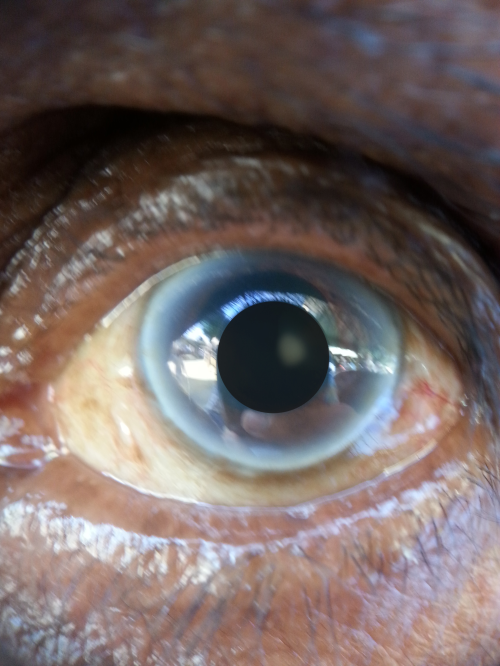

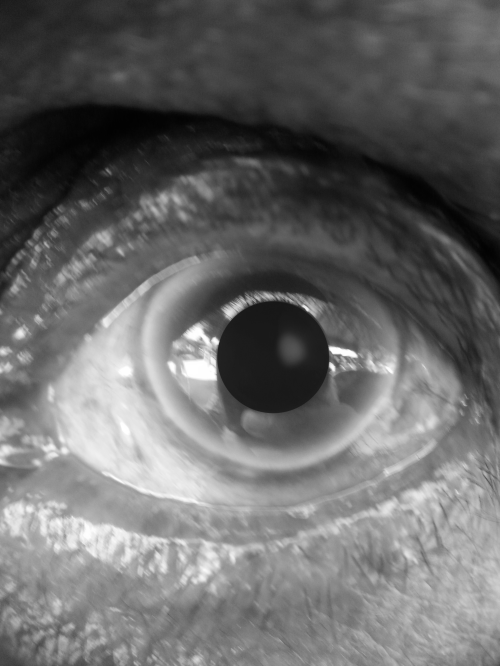

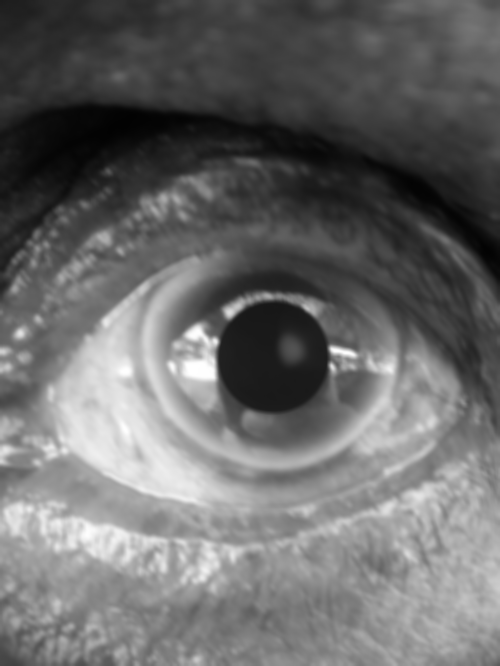

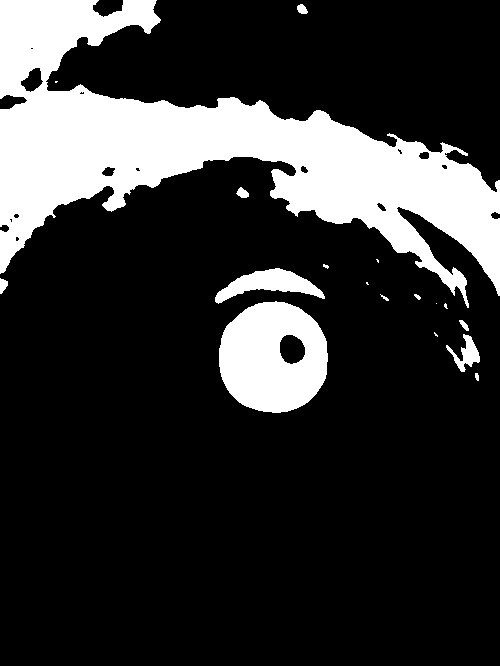

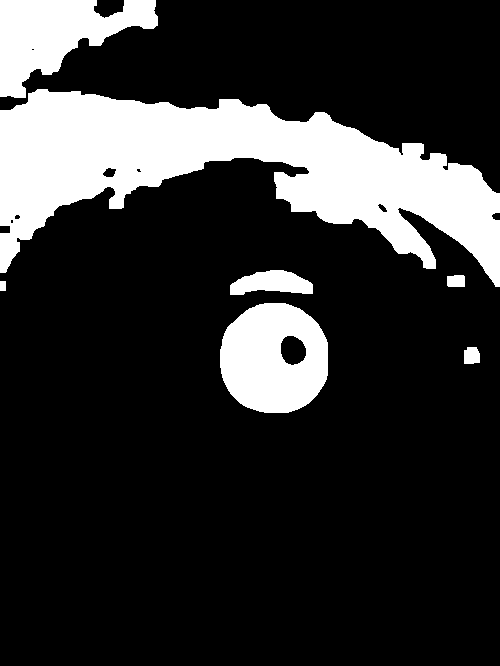

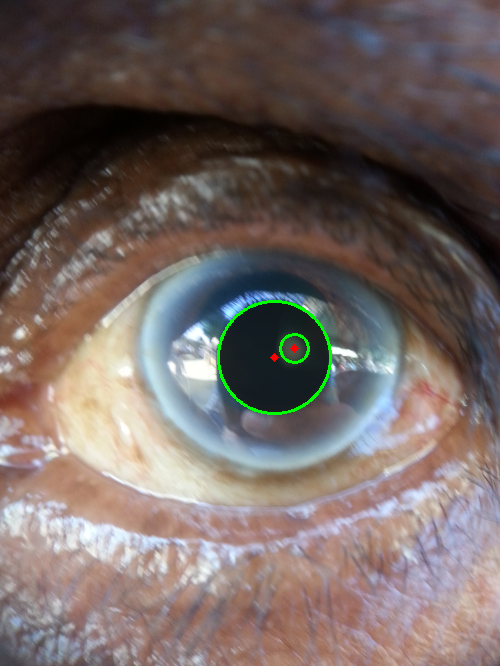

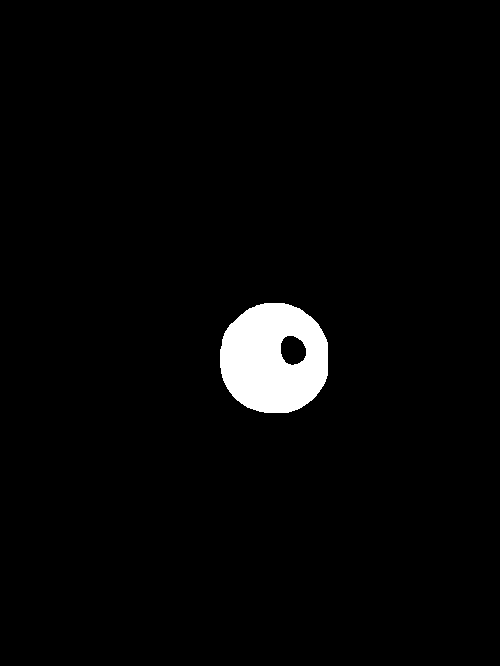

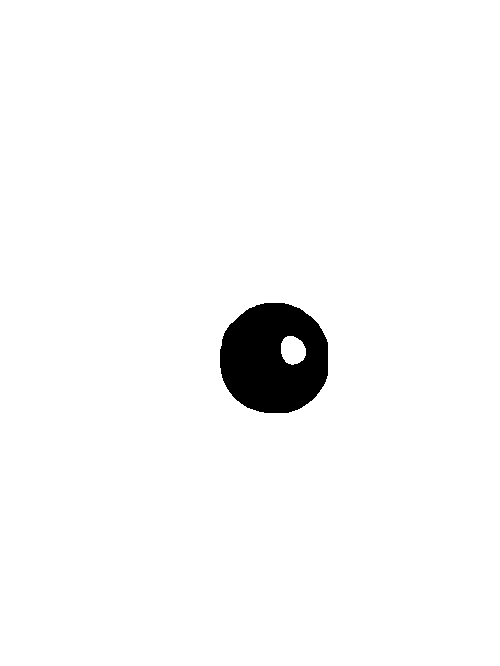

Pupil area:  9501.0
Centre of pupil: 273 358


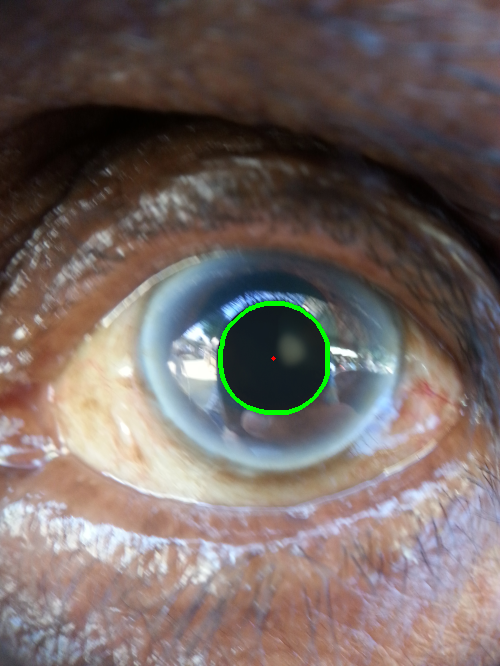

Cataract area:  529.0
Centre of cataract: 292 349
Cataract is 19 -9 away from pupil centre


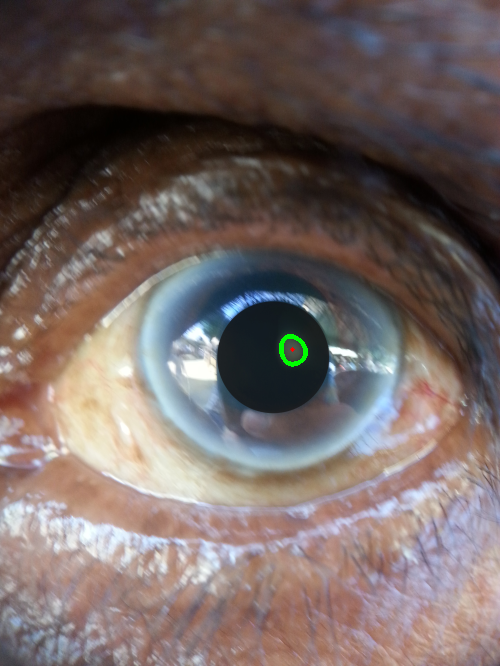

You have percent cataract 5.274177467597208


-1

In [ ]:
import cv2
import imutils
import numpy as np
from math import hypot
from google.colab.patches import cv2_imshow

pupil_area = 0          #variable to hold area of pupil
cat_area = 0            #variable to hold cataract area

cX_pupil = 0            # x coordiante of centre of pupil
cY_pupil = 0            # y coordinate of centre of pupil
cX_cat = 0              # x coordiante of centre of cataract
cY_cat = 0              # x coordiante of centre of cataract


img = cv2.imread('drive/My Drive/Colab Notebooks/Eye_Image_original.jpg')                    # Read the image
img = imutils.resize(img, width=500)            # Adjust the width of image - resizing
cv2_imshow(img)        # Display original image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # Grayscale conversion
cv2_imshow(gray)    # Display grascale image
kernel = np.ones((5,5),np.float32)/25           # Create smoothing kernel for filtering
imgfiltered = cv2.filter2D(gray,-1,kernel)      # Apply filtering
cv2_imshow(imgfiltered)      # Display Filtered Image

kernelOp = np.ones((10, 10), np.uint8)          # Create kernel for opening
kernelCl = np.ones((15, 15), np.uint8)          # Create kernel for closing

ret,thresh_image = cv2.threshold(imgfiltered,50,255,cv2.THRESH_BINARY_INV)      # Thresholding - darker areas made white and lighter areas made black - inert thresholding
cv2_imshow(thresh_image)                                     # Display image after thresholding
morpho = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, kernelOp)               # Opening (erode->dilate)
cv2_imshow(morpho)                                 # Display image after morphological opening
cimg_morpho = img.copy()                                                        # Copy the resultant image

# Find circular parts in the image
circles = cv2.HoughCircles(morpho, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

#Traverse over the circles
for i in circles[0,:]:
    cv2.circle(cimg_morpho,(i[0],i[1]),i[2],(0,255,0),2)        # Draw the outer circle
    cv2.circle(cimg_morpho,(i[0],i[1]),2,(0,0,255),3)           # Draw the center of the circle

cv2_imshow(cimg_morpho)                     # Display the image with circles detected
img_morpho_copy = morpho.copy()                                 # Copy the image resulting from morphological opening

circle_values_list = np.uint16(np.around(circles))              # Get values(centre x, centre y, radius) for all circles detected in the image
x, y, r = circle_values_list[0,:][0]                            # Assign values for centre-x, centre-y, radius
rows, cols = img_morpho_copy.shape                              # Get shape of the image

for i in range(cols):                                           # Traverse over the image columns
    for j in range(rows):                                       # Traverse over the image rows
        if hypot(i-x, j-y) > r:                                 # If the pixel lies outside the circle
            img_morpho_copy[j,i] = 0                            # Convert the pixel to black

imgg_inv = cv2.bitwise_not(img_morpho_copy)                     # Bitwise Not, to convert black to white and white to black
cv2_imshow(img_morpho_copy)      # Display image after morphological opening
cv2_imshow(imgg_inv)                     # Display image after detection and separation of circle - this is our mask


contours0, hierarchy = cv2.findContours(img_morpho_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)   # Find contours in the image
cimg_pupil = img.copy()                                                                                 # Copy the original image

for cnt in contours0:                                                   # Traverse over the contours
        cv2.drawContours(cimg_pupil, cnt, -1, (0, 255, 0), 3, 8)        # Draw the contours boundary on the original image copy
        pupil_area = cv2.contourArea(cnt)                               # Find area of contour
        print("Pupil area: ", pupil_area)                                # Print area of contour
        M = cv2.moments(cnt)                                            # Find moments of contour
        cX_pupil = int(M["m10"] / M["m00"])                             # Use moments to compute centre of mass - x coordinate
        cY_pupil = int(M["m01"] / M["m00"])                             # Use moments to compute centre of mass - y coordinate
        cv2.circle(cimg_pupil, (cX_pupil, cY_pupil), 2, (0, 0, 255), -1)# Draw a point(circle radius 2) on the image at the centre of mass computed
        print ("Centre of pupil:", cX_pupil, cY_pupil)       # Print the Centre of mass of pupil

cv2_imshow(cimg_pupil)                             # Display the image with the centre of mass of pupil drawn
cv2.imwrite("cimg_pupil.jpg",cimg_pupil)                                # Save this image

contours0, hierarchy = cv2.findContours(imgg_inv, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)      # Find Contour in the inverted image - here the cataract if any will be a contour
cimg_cat = img.copy()                                                                           # Copy the original image

for cnt in contours0:                                                   # Traverse over the contours
        if cv2.contourArea(cnt) < pupil_area:                           # If contour area is less than the pupil area - means could be cataract in eye
            cv2.drawContours(cimg_cat, cnt, -1, (0, 255, 0), 3, 8)      # Draw boundary of the contour on original image copy
            cat_area = cv2.contourArea(cnt)                             # Calculate cataract contour area
            print("Cataract area: ", cat_area)                           # Print Cataract area
            M = cv2.moments(cnt)                                        # Find moments of contour
            cX_cat = int(M["m10"] / M["m00"])                           # Use moments to compute centre of mass - x coordinate
            cY_cat = int(M["m01"] / M["m00"])                           # Use moments to compute centre of mass - y coordinate
            cv2.circle(cimg_cat, (cX_cat, cY_cat), 2, (0, 0, 255), -1)  # Draw point on the image at the centre of cataract
            print ("Centre of cataract:", cX_cat, cY_cat)    # Print the centre of cataract
            # Calculate Difference between pupil centre and cataract centre
            print ("Cataract is", cX_cat - cX_pupil, cY_cat - cY_pupil, "away from pupil centre")

cv2_imshow(cimg_cat)                           # Display the cataract contour on the original image copy
cataract_percentage = (cat_area / (pupil_area + cat_area)) * 100        # Calculate percentage of cataract developed
print ("You have percent cataract", cataract_percentage)        # Display percentage of cataract developed

cv2.waitKey(0)

In [ ]:
123